In [18]:
from datamarket import *
import autosklearn.classification
import autosklearn.metrics
import time

# Read the data and train model without augmentation
We first use factorized linear regression, then automl.

In [4]:
# read buyer dataset
buyer = pd.read_csv("gender.csv")

# train test split
msk = split_mask(len(buyer)) < 0.8
buyer_train = buyer[msk].copy()
buyer_test = buyer[~msk].copy()

In [5]:
buyer_train_data = agg_dataset()
buyer_train_data.load(buyer_train, ["Number Tested", "Mean Scale Score"], ["DBN", ["DBN","Grade"], "Year", "Category"], "buyer")
buyer_train_data.process_target("Mean Scale Score")
buyer_train_data.to_numeric_and_impute_all()
buyer_train_data.remove_redundant_columns()
buyer_train_data.create_count_true()
buyer_train_data.compute_agg()

buyer_test_data = agg_dataset()
buyer_test_data.load(buyer_test, ["Number Tested", "Mean Scale Score"], ["DBN", ["DBN","Grade"], "Year", "Category"], "buyer")
buyer_test_data.process_target("Mean Scale Score")
buyer_test_data.to_numeric_and_impute_all()
buyer_test_data.remove_redundant_columns()
buyer_test_data.create_count_true()
buyer_test_data.compute_agg()

In [6]:
# model performance before augmentation with linear regression
train_cov = buyer_train_data.covariance
test_cov = buyer_test_data.covariance
X = ['Number Tested']
y = 'Mean Scale Score'

parameter = linear_regression(train_cov, ["buyer:" + x for x in X], "buyer:" + y)
print("R2 score is:" + str(r2(test_cov, ["buyer:" + x for x in X], "buyer:" + y, parameter)))

R2 score is:0.00870173150760123


In [11]:
time_budget = 300

In [12]:
# preprocess data
categories = ['Year', "Grade", "Category"]
for cate in categories:
    buyer = buyer.astype({cate: 'category'})

buyer[y] = pd.to_numeric(buyer[y], errors='coerce')
buyer.dropna(subset=[y],inplace=True)
msk = split_mask(len(buyer)) < 0.8
buyer_train = buyer[msk].copy()
buyer_test = buyer[~msk].copy()

# model performance with autoML 
X_train = buyer_train[X + categories]
y_train = buyer_train[y]
X_test = buyer_test[X + categories]
y_test = buyer_test[y]

automl = autosklearn.regression.AutoSklearnRegressor(
# automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=time_budget,
    per_run_time_limit=int(time_budget/3),
    memory_limit=6072
#     metric=autosklearn.metrics.r2
)
automl.fit(X_train, y_train, X_test, y_test, dataset_name='buyer')

now_n = datetime.now()
current_time = now_n.strftime("%H:%M:%S")
print("Current Time =", current_time)

[WARNING] [2022-04-15 23:19:36,255:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2022-04-15 23:19:55,650:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 2. Number of dummy models: 1
Current Time = 23:24:04


<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

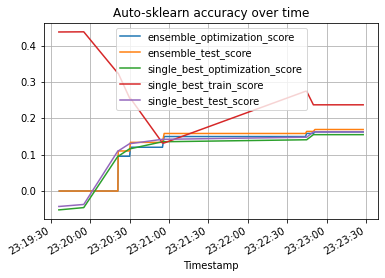

In [15]:
poT = automl.performance_over_time_
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

# Load seller datasets and build market

In [16]:
import json
with open('market_data.json', 'r') as openfile:
    market_data = json.load(openfile)
    
sellers = []

for data in market_data:
    file, dimension, name = data
    df = pd.read_csv(file)
    aggdata = agg_dataset()
    aggdata.load(df, [], dimension, name)
    aggdata.find_features()
    aggdata.remove_redundant_columns()
    aggdata.compute_agg(True)
    aggdata.create_count_true()
    sellers.append((aggdata, dimension[0]))

/home/jupyter/arda/arda-datasets/kitana/datamarket.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data['cov:Q:' + tablename + ":" + attributes[i] + ","+ tablename + ":" + attributes[j]] = self.data[attributes[i]] * self.data[attributes[j]]


In [17]:
buyer

,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,Level1_N,Level1_%,Level2_N,Level2_%,Level3_N,Level3_%,Level4_N,Level4_%,Level3+4_N,Level3+4_%
0,01M015,PS 015 ROBERTO CLEMENTE,3,2013,Female,12,285.0,7,58.3,5,41.7,0,0.0,0,0.0,0,0.0
1,01M015,PS 015 ROBERTO CLEMENTE,3,2013,Male,15,292.0,7,46.7,6,40.0,2,13.3,0,0.0,2,13.3
4,01M015,PS 015 ROBERTO CLEMENTE,3,2015,Female,7,289.0,3,42.9,3,42.9,1,14.3,0,0.0,1,14.3
5,01M015,PS 015 ROBERTO CLEMENTE,3,2015,Male,9,276.0,6,66.7,2,22.2,1,11.1,0,0.0,1,11.1
8,01M015,PS 015 ROBERTO CLEMENTE,3,2017,Female,13,308.0,4,30.8,4,30.8,3,23.1,2,15.4,5,38.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47730,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,2015,Male,161,274.0,98,60.9,52,32.3,11,6.8,0,0.0,11,6.8
47731,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,2016,Female,125,286.0,48,38.4,63,50.4,12,9.6,2,1.6,14,11.2
47732,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,2016,Male,141,282.0,62,44.0,70,49.6,9,6.4,0,0.0,9,6.4
47733,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,2017,Female,138,289.0,49,35.5,70,50.7,14,10.1,5,3.6,19,13.8


In [21]:
start = time.time()

m = 1
# budget = 140000
for i in range(m):
    best_seller = None
    best_seller_attrs = []
    best_dimension = None
    best_r2 = 0

    for sellerdata, dimension in sellers:
        print(sellerdata.name)
#         pd.merge(buyer_train_data.data, sellerdata.data, left_on=dimension, right_on=dimension)
        # check if current seller has been bought
        if sellerdata.name in buyer_train_data.datasets:
            continue
            
#         count_true_join = connect_count(buyer_train_data, sellerdata, dimension)
#         if count_true_join["cov:c"].sum() > budget:
#             print("beyond budget!!")
#             continue
        

        # find the attributes and r2 of augmenting
        cur_atts, final_r2 = select_features(buyer_train_data, buyer_test_data, sellerdata, dimension,6, y)
        print(cur_atts, final_r2)
        if final_r2 > best_r2:
            best_seller = sellerdata
            best_dimension = dimension
            best_seller_attrs = cur_atts
            best_r2 = final_r2

    print(best_seller.name, best_seller_attrs, best_r2)
    
#     if len([x for x in best_seller_attrs if x in best_seller.X]) == 0:
#         buyer_train_data.datasets.add(best_seller)
#         buyer_test_data.datasets.add(best_seller)
#     else:
#         buyer_train_data.absorb(best_seller, best_dimension, best_seller_attrs + [buyer_train_data.name + ":" + y])
#         buyer_test_data.absorb(best_seller, best_dimension, best_seller_attrs + [buyer_train_data.name + ":" + y])

end = time.time()

disc
['disc:ADMINISTRATIVE DISTRICT', 'buyer:Number Tested', 'disc:SY1617 TOTAL REMOVALS/SUSPENSIONS'] 0.01809409651495142
esl
['esl:Level 3+4 %', 'esl:Level 3 %', 'esl:Mean Scale Score', 'esl:Level 4 #', 'esl:Grade', 'esl:Level 2 #'] 0.4357000026310125
math
['math:Level 4 %', 'math:Level 1 %', 'math:Grade', 'math:Year', 'math:Mean Scale Score', 'math:Level 4 #'] 0.4008744384393087
oss
['oss:ADMINISTRATIVE DISTRICT', 'buyer:Number Tested'] 0.0200527935933692
pe
['pe:Student Enrollment', 'pe:Full Time Licensed PE Teachers', 'pe:Total Part Time and Full Time PE Teachers*', 'buyer:Number Tested', 'pe:Geographical District', 'pe:Admin District'] 0.10373135904818298
s2tr
['s2tr:School Pupil-Teacher Ratio', 'buyer:Number Tested'] 0.21007728228589773
sat
['buyer:Number Tested', 'sat:Writing Mean', 'sat:Number of Test Takers', 'sat:Mathematics Mean', 'sat:Critical Reading Mean'] 0.010881058613883776
pro
['pro:2012-2013 PERFORMANCE CATEGORY SCORE', 'pro:2012-2013 ADDITIONAL CREDIT', 'pro:DISTRI

In [30]:
# make best_dimension a list
if isinstance(best_dimension, tuple):
    best_dimension = list(best_dimension)
else:
    best_dimension = [best_dimension]

# extract needed attributes
seller_features = ['cov:s:' +  attr for attr in best_seller_attrs  if attr.startswith(best_seller.name)]
buyer_features = ['cov:s:' +  attr for attr in best_seller_attrs  if not attr.startswith(best_seller.name)]
target = ['cov:s:buyer:' + y]
buyer_train_data_df = buyer_train_data.data[buyer_train_data.dedup_dimensions + buyer_features + target]
buyer_test_data_df = buyer_test_data.data[buyer_train_data.dedup_dimensions + buyer_features + target]
seller_data = best_seller.data[best_dimension + seller_features]
# seller_data = seller_data.groupby(best_dimension).mean()

# join buyer and seller
join_train = pd.merge(buyer_train_data_df,seller_data,how='left', on=best_dimension)
join_test = pd.merge(buyer_test_data_df,seller_data,how='left', on=best_dimension)

for cate in categories:
    join_train = join_train.astype({cate: 'category'})
    join_test = join_test.astype({cate: 'category'})

In [25]:
timeleft = time_budget - (end - start)

In [27]:
%%time
# model performance with autoML 
X_train = join_train[categories + seller_features + buyer_features]
y_train = join_train[target]
X_test = join_test[categories + seller_features + buyer_features]
y_test = join_test[target]

automl = autosklearn.regression.AutoSklearnRegressor(
# automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=int(timeleft),
    per_run_time_limit=int(timeleft/3),
    memory_limit=23072
#     ,metric=autosklearn.metrics.r2
)

automl.fit(X_train, y_train, X_test, y_test, dataset_name='buyer')

CPU times: user 1.09 s, sys: 1.57 s, total: 2.66 s
Wall time: 4min 9s


AutoSklearnRegressor(memory_limit=23072, per_run_time_limit=83,
                     time_left_for_this_task=249)

Train R2 score: 0.9290096152480338
Test R2 score: 0.8356692896092124
          rank  ensemble_weight           type      cost  duration
model_id                                                          
2            1              1.0  random_forest  0.168266  71.84827
                   Timestamp  ensemble_optimization_score  \
1 2022-04-16 00:10:08.000000                          NaN   
0 2022-04-16 00:10:08.232887                     0.831734   

   ensemble_test_score  single_best_optimization_score  \
1                  NaN                        0.831734   
0             0.835669                        0.831734   

   single_best_train_score  single_best_test_score  
1                 0.976062                0.835669  
0                 0.976062                0.835669  


<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

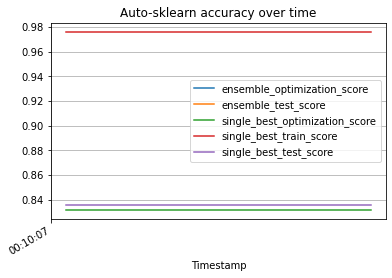

In [28]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)